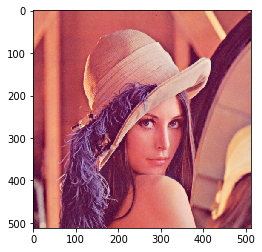

In [45]:
# Load lena

import urllib.request
from matplotlib import pyplot as plt
import numpy as np
import cv2 # pip install opencv-python

%matplotlib inline
HTTP_response = urllib.request.urlopen('http://www.hpca.ual.es/~vruiz/images/lena.png')
arr = np.asarray(bytearray(HTTP_response.read()), dtype=np.uint8)
BRG = cv2.imdecode(arr,-1)
pixels = cv2.cvtColor(BRG, cv2.COLOR_BGR2RGB)
plt.imshow(pixels)

In [46]:
# Color 2D-DWT is the 2D-DWT of each component
components = ('r','g','b')
coeffs = [None]*3
wavelet_= 'haar'
levels_ = 5
for i,com in enumerate(components):
    print("{} ".format(i), end='')
    coeffs[i] = pywt.wavedec2(pixels[:,:,i], wavelet=wavelet_, level=levels_)

0 1 2 

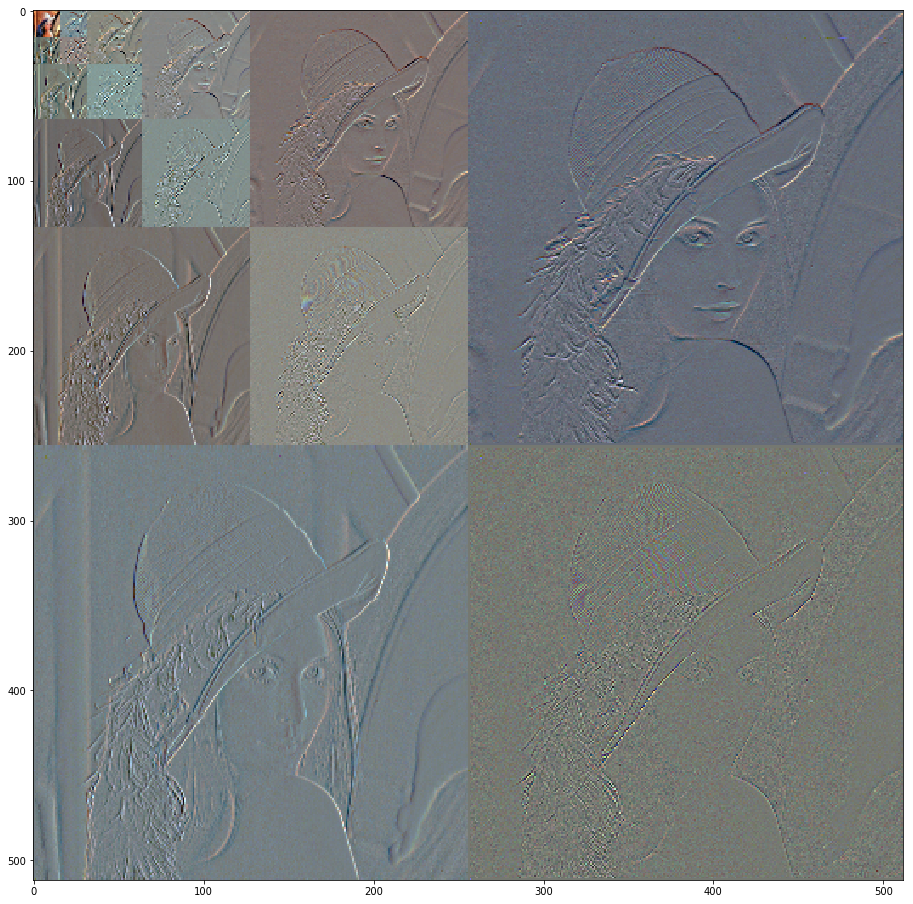

In [47]:
# View DWT coefs

fig = plt.figure(figsize=(16, 16))

view = np.empty(pixels.shape, 'uint8')

# LL subband
for i,com in enumerate(components):
    x = coeffs[i][0][:,:]
    y = ((x - x.min()) / (x.max() - x.min())*255).astype('uint8')
    view[0:coeffs[i][0].shape[0],
         0:coeffs[i][0].shape[1],
         i] = y

for l in range(levels_):

    # LH
    for i,com in enumerate(components):
        x = coeffs[i][l+1][0][:,:]
        y = ((x - x.min()) / (x.max() - x.min())*255).astype('uint8')
        view[0:coeffs[i][l+1][0].shape[0],
             coeffs[i][l+1][0].shape[1]:coeffs[i][l+1][0].shape[1]*2,
             i] = y

    # HH
    for i,com in enumerate(components):
        x = coeffs[i][l+1][1][:,:]
        y = ((x - x.min()) / (x.max() - x.min())*255).astype('uint8')
        view[coeffs[i][l+1][1].shape[0]:coeffs[i][l+1][1].shape[0]*2,
             0:coeffs[i][l+1][1].shape[1],
             i] = y

    # HH
    for i,com in enumerate(components):
        x = coeffs[i][l+1][2][:,:]
        y = ((x - x.min()) / (x.max() - x.min())*255).astype('uint8')
        view[coeffs[i][l+1][2].shape[0]:coeffs[i][l+1][2].shape[0]*2,
             coeffs[i][l+1][2].shape[1]:coeffs[i][l+1][2].shape[1]*2,
             i] = y

plt.subplot(1, 1, 1)
plt.imshow(view)

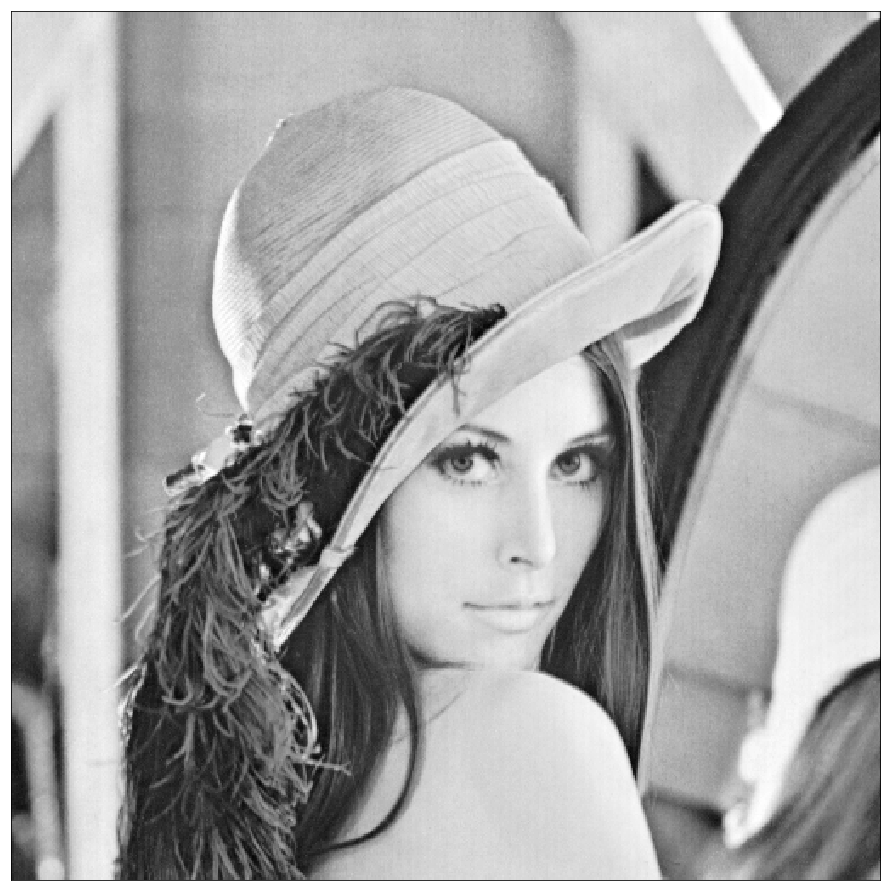

In [48]:
recons_ = pywt.waverec2(coeffs[0], wavelet=wavelet_)
max = recons_.max()
min = recons_.min()
if(max!=min):
    recons = (recons_-min)/(max-min)*255

# Visualize
fig = plt.figure(figsize=(16, 16))

plt.imshow(recons, cmap=plt.cm.gray)
plt.grid(False);
plt.xticks([]);
plt.yticks([]);
plt.show()

255 0


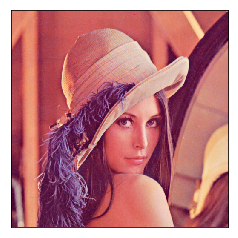

In [49]:
recons = np.empty(pixels.shape)

recons[:,:,0] = pywt.waverec2(coeffs[0], wavelet=wavelet_)
recons[:,:,1] = pywt.waverec2(coeffs[1], wavelet=wavelet_)
recons[:,:,2] = pywt.waverec2(coeffs[2], wavelet=wavelet_)
max = recons.max()
min = recons.min()
if(max!=min):
    recons = ((recons-min)/(max-min)*255).astype('uint8')
                      
# Visualize
print(recons.max(), recons.min())
plt.imshow(recons)
plt.grid(False);
plt.xticks([]);
plt.yticks([]);
plt.show()

### Progressive transmission

100 coefficients

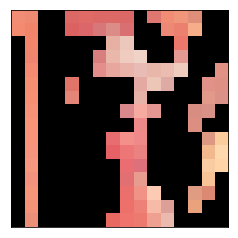

200 coefficients

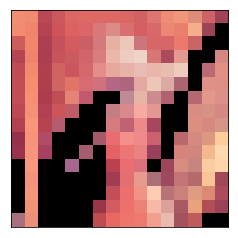

300 coefficients

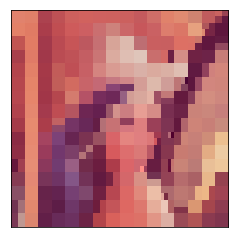

400 coefficients

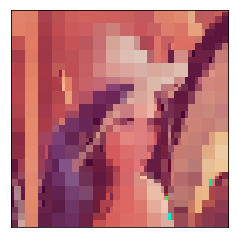

500 coefficients

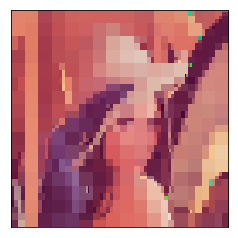

600 coefficients

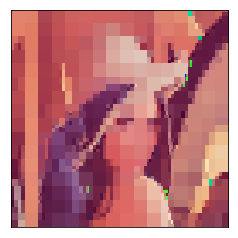

700 coefficients

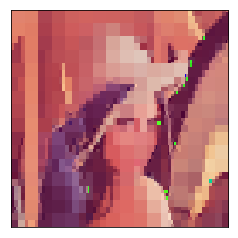

800 coefficients

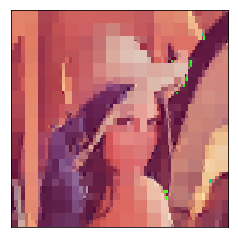

900 coefficients

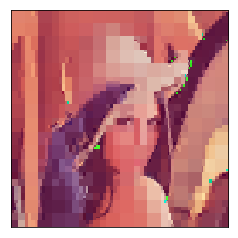

1000 coefficients

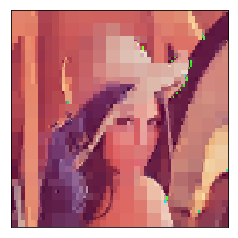

In [50]:
# Reconstruct with biggest DWT coefs
recons = np.empty(pixels.shape)

N = 100 # Step size (in coeffs) for each reconstruction
for k in range(10): # Up to 32 reconstructions

    coeffs_indexes = np.empty((pixels.shape[0] * pixels.shape[1]),
                            dtype='float, int, int, int, int')
                            # Coeff, level, subband, coor_x, coor_y

    # Process only the R component to find the higher coeffs
    
    offset = 0
    
    # LL
    for x in range(coeffs[0][0].shape[0]):
        for y in range(coeffs[0][0].shape[1]):
            coeffs_indexes[offset] = (np.abs(coeffs[0][0][x][y]), 0, 0, x, y)
            offset += 1
    
    # Rest of subbands
    for l in range(levels_):
        for s in range(3):
            for x in range(coeffs[0][l+1][s].shape[0]):
                for y in range(coeffs[0][l+1][s].shape[1]):
                    coeffs_indexes[offset] = (np.abs(coeffs[0][l+1][s][x][y]), (l+1), s, x, y)
                    offset += 1

    sorted = np.zeros((pixels.shape[0] * pixels.shape[1]), dtype='float, int, int, int, int')
    sorted = np.sort(coeffs_indexes)[::-1]

    # Reconstruct R

    # An "empty" transformed structure

    zeros = np.zeros((pixels.shape[0], pixels.shape[1]))
    filtered_coeffs = pywt.wavedec2(zeros, wavelet=wavelet_, level=levels_)

    # Copy some coeffs
    for kk in range((k+1)*N):
        if sorted[kk][1] == 0:
            filtered_coeffs[0][sorted[kk][3], sorted[kk][4]] = \
            coeffs[0][0][sorted[kk][3], sorted[kk][4]]
        else:
            #print(kk, sorted[kk][1], sorted[kk][2], sorted[kk][3], sorted[kk][4])
            filtered_coeffs[sorted[kk][1]][sorted[kk][2]][sorted[kk][3], sorted[kk][4]] = \
            coeffs[0][sorted[kk][1]][sorted[kk][2]][sorted[kk][3], sorted[kk][4]]
        
    recons_ = pywt.waverec2(filtered_coeffs, wavelet=wavelet_)
    recons[:,:,0] = recons_

    # Reconstruct G

    # An "empty" transformed structure

    zeros = np.zeros((pixels.shape[0], pixels.shape[1]))
    filtered_coeffs = pywt.wavedec2(zeros, wavelet=wavelet_, level=levels_)

    # Copy some coeffs
    for kk in range((k+1)*N):
        if sorted[kk][1] == 0:
            filtered_coeffs[0][sorted[kk][3], sorted[kk][4]] = \
            coeffs[1][0][sorted[kk][3], sorted[kk][4]]
        else:
            filtered_coeffs[sorted[kk][1]][sorted[kk][2]][sorted[kk][3], sorted[kk][4]] = \
            coeffs[1][sorted[kk][1]][sorted[kk][2]][sorted[kk][3], sorted[kk][4]]
        
    recons_ = pywt.waverec2(filtered_coeffs, wavelet=wavelet_)
    recons[:,:,1] = recons_
    
    # Reconstruct B

    # An "empty" transformed structure
    zeros = np.zeros((pixels.shape[0], pixels.shape[1]))
    filtered_coeffs = pywt.wavedec2(zeros, wavelet=wavelet_, level=levels_)

    # Copy some coeffs
    for kk in range((k+1)*N):
        if sorted[kk][1] == 0:
            filtered_coeffs[0][sorted[kk][3], sorted[kk][4]] = \
            coeffs[2][0][sorted[kk][3], sorted[kk][4]]
        else:
            filtered_coeffs[sorted[kk][1]][sorted[kk][2]][sorted[kk][3], sorted[kk][4]] = \
            coeffs[2][sorted[kk][1]][sorted[kk][2]][sorted[kk][3], sorted[kk][4]]

    recons_ = pywt.waverec2(filtered_coeffs, wavelet=wavelet_)
    recons[:,:,2] = recons_
                      
    max = recons.max()
    min = recons.min()
    if(max!=min):
        recons = ((recons-min)/(max-min)*255).astype('uint8')

    # Visualize
    plt.imshow(recons)
    plt.grid(False);
    plt.xticks([]);
    plt.yticks([]);
    print("{} coefficients".format((k+1)*N), end='')
    plt.show()